# Data Vault Demo (Quant, can also score own portfolio)

The basic concept of the Data Vault is that when a user authenticates themself, they receive an engine that gives them access to all the data (rows, columns, tables, schema, etc.) for which they are authorized.  Users who can authenticate themselves for multiple roles can use those roles simultaneously.  We are keeping in mind the importance of Data Lineage Management (tracked by issue https://github.com/os-climate/os_c_data_commons/issues/50) but is not treated as part of this particular prototype.

The steps of this demo are:

1. **Authenticate and acquire SQLAlchemy engine**
    1. Dev engine sees all
    2. **Quant engine can do temp scoring but not see fundamental company info**
    3. User engine can use temp scoring but not see cumulative emissions nor overshoot info
2. With Dev engine, construct Vaults for:
    1. Fundamental corporate financial information
    2. Corporate emissions data (base year, historical)
    3. Corporate target data (start year, end year, target start value, target end value)
    4. Sector benchmark data (production, CO2e intensity)
3. Dev Engine: Visualize projected emissions (targets and trajectories) and calculate cumulative emissions
4. **Quant Engine: Using calculated cumulative emmisions, visualize per-company trajectory and target temperature scores**
5. User Engine: Using consensus probability scoring and own portfolio data (ISIN, position value)
    1. Calculate publishable per-company temperature alignment score
    2. Based on aggregate corporate and portfolio information, produce weighting scores to yield overall portfolio alignment score

In [1]:
import os
import pathlib
import osc_ingest_trino as osc
import re
import trino
from sqlalchemy.engine import create_engine

import json
import numpy as np
import pandas as pd
import ITR
from ITR_examples import data_dir as xlsx_data_dir

# from ITR.portfolio_aggregation import PortfolioAggregationMethod
# from ITR.temperature_score import TemperatureScore
# from ITR.configs import ColumnsConfig, TemperatureScoreConfig
# from ITR.data.data_warehouse import DataWarehouse
from ITR.data.vault_providers import (
    VaultCompanyDataProvider,
    VaultProviderProductionBenchmark,
    VaultProviderIntensityBenchmark,
    DataVaultWarehouse,
    requantify_df,
)

# from ITR.interfaces import ICompanyData, EScope, ETimeFrames, PortfolioCompany, IEIBenchmarkScopes, \
#     IProductionBenchmarkScopes
from ITR.interfaces import EScope, IProductionBenchmarkScopes, IEIBenchmarkScopes
from ITR.data.osc_units import ureg, Q_, PA_

ingest_catalog = "osc_datacommons_dev"
ingest_schema = "demo_dv"
itr_prefix = "itr_"

osc.load_credentials_dotenv()

company_data_path = os.path.join(xlsx_data_dir, "20220927 ITR V2 Sample Data.xlsx")

### Step 1: Initialize Vault user 'Quant', which has limited visibility into corporate financial, production, and target data

### The ITR module provides Vault objects that coordinate the interaction of Dev, Quant, and User roles.

The SQLAlchemy engines mediate the actual interaction with the Data Vault.

In [2]:
engine_quant = osc.attach_trino_engine(verbose=True, catalog=ingest_catalog, schema=ingest_schema)
print("connecting with engine " + str(engine_quant))
osc._do_sql(f"show tables in {ingest_schema}", engine_quant, verbose=True)

using connect string: trino://MichaelTiemannOSC@trino-secure-odh-trino.apps.odh-cl2.apps.os-climate.org:443/osc_datacommons_dev/demo_dv
connecting with engine Engine(trino://MichaelTiemannOSC@trino-secure-odh-trino.apps.odh-cl2.apps.os-climate.org:443/osc_datacommons_dev/demo_dv)
show tables in demo_dv
[('itr_benchmark_ei',), ('itr_benchmark_prod',), ('itr_company_data',), ('itr_cumulative_budgets',), ('itr_cumulative_emissions',), ('itr_emissions_data',), ('itr_overshoot_ratios',), ('itr_production_data',), ('itr_target_data',), ('itr_temperature_scores',), ('itr_trajectory_data',)]


[('itr_benchmark_ei',),
 ('itr_benchmark_prod',),
 ('itr_company_data',),
 ('itr_cumulative_budgets',),
 ('itr_cumulative_emissions',),
 ('itr_emissions_data',),
 ('itr_overshoot_ratios',),
 ('itr_production_data',),
 ('itr_target_data',),
 ('itr_temperature_scores',),
 ('itr_trajectory_data',)]

### The ITR module provides Vault objects that coordinate the interaction of Dev, Quant, and User roles.

The SQLAlchemy engines mediate the actual interaction with the Data Vault.

### Steps 2 & 3: Done in Dev part of 02_vault_dev

### Step 4: Use Quant engine to access and visualize temperature scores

When the Data Vault is ready to be implemented, we can demonstrate that the Quant engine does not have access to primary company data (neither financial nor production)

Show that we *cannot* access fundamental company data (cannot show until op1st team changes permissions)

In [3]:
vault_company_data = VaultCompanyDataProvider(
    engine_quant,
    company_table=f"{itr_prefix}company_data",
    target_table=None,
    trajectory_table=None,
    company_schema="demo_dv",
    template_company_data=None,
    column_config=None,
)

In [4]:
vault_warehouse = DataVaultWarehouse(
    engine_quant,
    company_data=None,
    benchmark_projected_production=None,
    benchmarks_projected_ei=None,
    ingest_schema="demo_dv",
    itr_prefix=itr_prefix,
    column_config=None,
)

vault_warehouse.quant_init(
    engine_quant, company_data=vault_company_data, ingest_schema="demo_dv", itr_prefix=itr_prefix
)


create table demo_dv.itr_overshoot_ratios with (
    format = 'ORC',
    partitioning = array['scope']
) as
select E.company_name, E.company_id, 'demo_dv' as source, B.year, -- FIXME: should have scenario_name and year released
       B.global_budget, B.benchmark_temp,
       E.cumulative_trajectory/B.cumulative_budget as trajectory_overshoot_ratio,
       concat(E.cumulative_trajectory_units, ' / (', B.cumulative_budget_units, ')') as trajectory_overshoot_ratio_units,
       E.cumulative_target/B.cumulative_budget as target_overshoot_ratio,
       concat(E.cumulative_target_units, ' / (', B.cumulative_budget_units, ')') as target_overshoot_ratio_units,
       B.scope
from demo_dv.itr_cumulative_emissions E
     join demo_dv.itr_cumulative_budgets B on E.company_id=B.company_id and E.scope=B.scope and E.year=B.year

[(6144,)]

create table demo_dv.itr_temperature_scores with (
    format = 'ORC',
    partitioning = array['scope']
) as
select R.company_name, R.company_id, 'demo_dv' as 

In [5]:
ureg.setup_matplotlib(True)
%matplotlib inline

Show that we *can* access both cumulative emissions (input) and temperature scores (output)

In [6]:
sql_temp_score_df = pd.read_sql_table(f"{itr_prefix}temperature_scores", engine_quant).replace(
    [np.inf, -np.inf], np.nan
)

/Users/michael/virtualenvs/itr-examples/lib/python3.11/site-packages/pandas/io/sql.py:1665: SAWarning: index key 'partition' was not located in columns for table 'itr_temperature_scores'
  self.meta.reflect(bind=self.con, only=[table_name], views=True)
/Users/michael/virtualenvs/itr-examples/lib/python3.11/site-packages/pandas/io/sql.py:1665: SAWarning: index key 'record_count' was not located in columns for table 'itr_temperature_scores'
  self.meta.reflect(bind=self.con, only=[table_name], views=True)
/Users/michael/virtualenvs/itr-examples/lib/python3.11/site-packages/pandas/io/sql.py:1665: SAWarning: index key 'file_count' was not located in columns for table 'itr_temperature_scores'
  self.meta.reflect(bind=self.con, only=[table_name], views=True)
/Users/michael/virtualenvs/itr-examples/lib/python3.11/site-packages/pandas/io/sql.py:1665: SAWarning: index key 'total_size' was not located in columns for table 'itr_temperature_scores'
  self.meta.reflect(bind=self.con, only=[table_na

In [7]:
temp_score_df = requantify_df(
    sql_temp_score_df, typemap={"trajectory_temperature_score": "delta_degC", "target_temperature_score": "delta_degC"}
)
temp_score_df = temp_score_df[
    ~temp_score_df.company_id.isin(
        [
            "US6362744095+Gas Utilities",
            "US0236081024+Gas Utilities",
            "CA87807B1076+Gas",
            "CA87807B1076+Oil",
            "NO0010657505",
        ]
    )
]
temp_score_df

,company_name,company_id,source,year,trajectory_temperature_score,target_temperature_score,scope
0,Tesla,US88160R1014,demo_dv,2019,1.262376003666861,1.262376003666861,S1S2S3
1,Tesla,US88160R1014,demo_dv,2024,1.2623468135111042,1.2623453059381076,S1S2S3
2,Tesla,US88160R1014,demo_dv,2026,1.2623396322425902,1.2623371753319073,S1S2S3
3,Tesla,US88160R1014,demo_dv,2030,1.2623421099526757,1.262337706955513,S1S2S3
4,Tesla,US88160R1014,demo_dv,2039,1.2623605153170931,1.262351864025783,S1S2S3
...,...,...,...,...,...,...,...
6139,WEC Energy Group,US92939U1060,demo_dv,2041,2.4673043311879734,1.9605267820593824,S1
6140,WEC Energy Group,US92939U1060,demo_dv,2044,2.5917695371156872,1.975201259296,S1
6141,WEC Energy Group,US92939U1060,demo_dv,2047,2.7052167277155554,1.9790882417389735,S1
6142,WEC Energy Group,US92939U1060,demo_dv,2048,2.740287096040869,1.97821904346716,S1


In [8]:
plottable_df = (
    temp_score_df.loc[
        temp_score_df.year == 2050,
        ["company_name", "scope", "trajectory_temperature_score", "target_temperature_score"],
    ]
    .sort_values(by="company_name")
    .set_index(["company_name", "scope"])
)

In [9]:
plottable_df["average_score"] = (
    plottable_df["trajectory_temperature_score"] + plottable_df["target_temperature_score"]
) / 2.0

In [10]:
plottable_df = plottable_df.T.pint.dequantify()

In [11]:
plottable_df.dropna(axis=1, how="all").iloc[:, 0:5]

company_name                            AES Corp.                       \
scope                                      S1S2S3                 S1S2   
unit                         delta_degree_Celsius delta_degree_Celsius   
trajectory_temperature_score             4.078356             3.458375   
target_temperature_score                 1.262808               1.7413   
average_score                            2.670582             2.599837   

company_name                                                            \
scope                                          S1                   S2   
unit                         delta_degree_Celsius delta_degree_Celsius   
trajectory_temperature_score              3.47569             2.624513   
target_temperature_score                 1.722559             1.445626   
average_score                            2.599124              2.03507   

company_name                         ALLETE, Inc.  
scope                                          S2  
unit                         delta_degree_Celsius  
trajectory_temperature_score             1.262227  
target_temperature_score                 1.262227  
average_score                            1.262227

<Axes: >

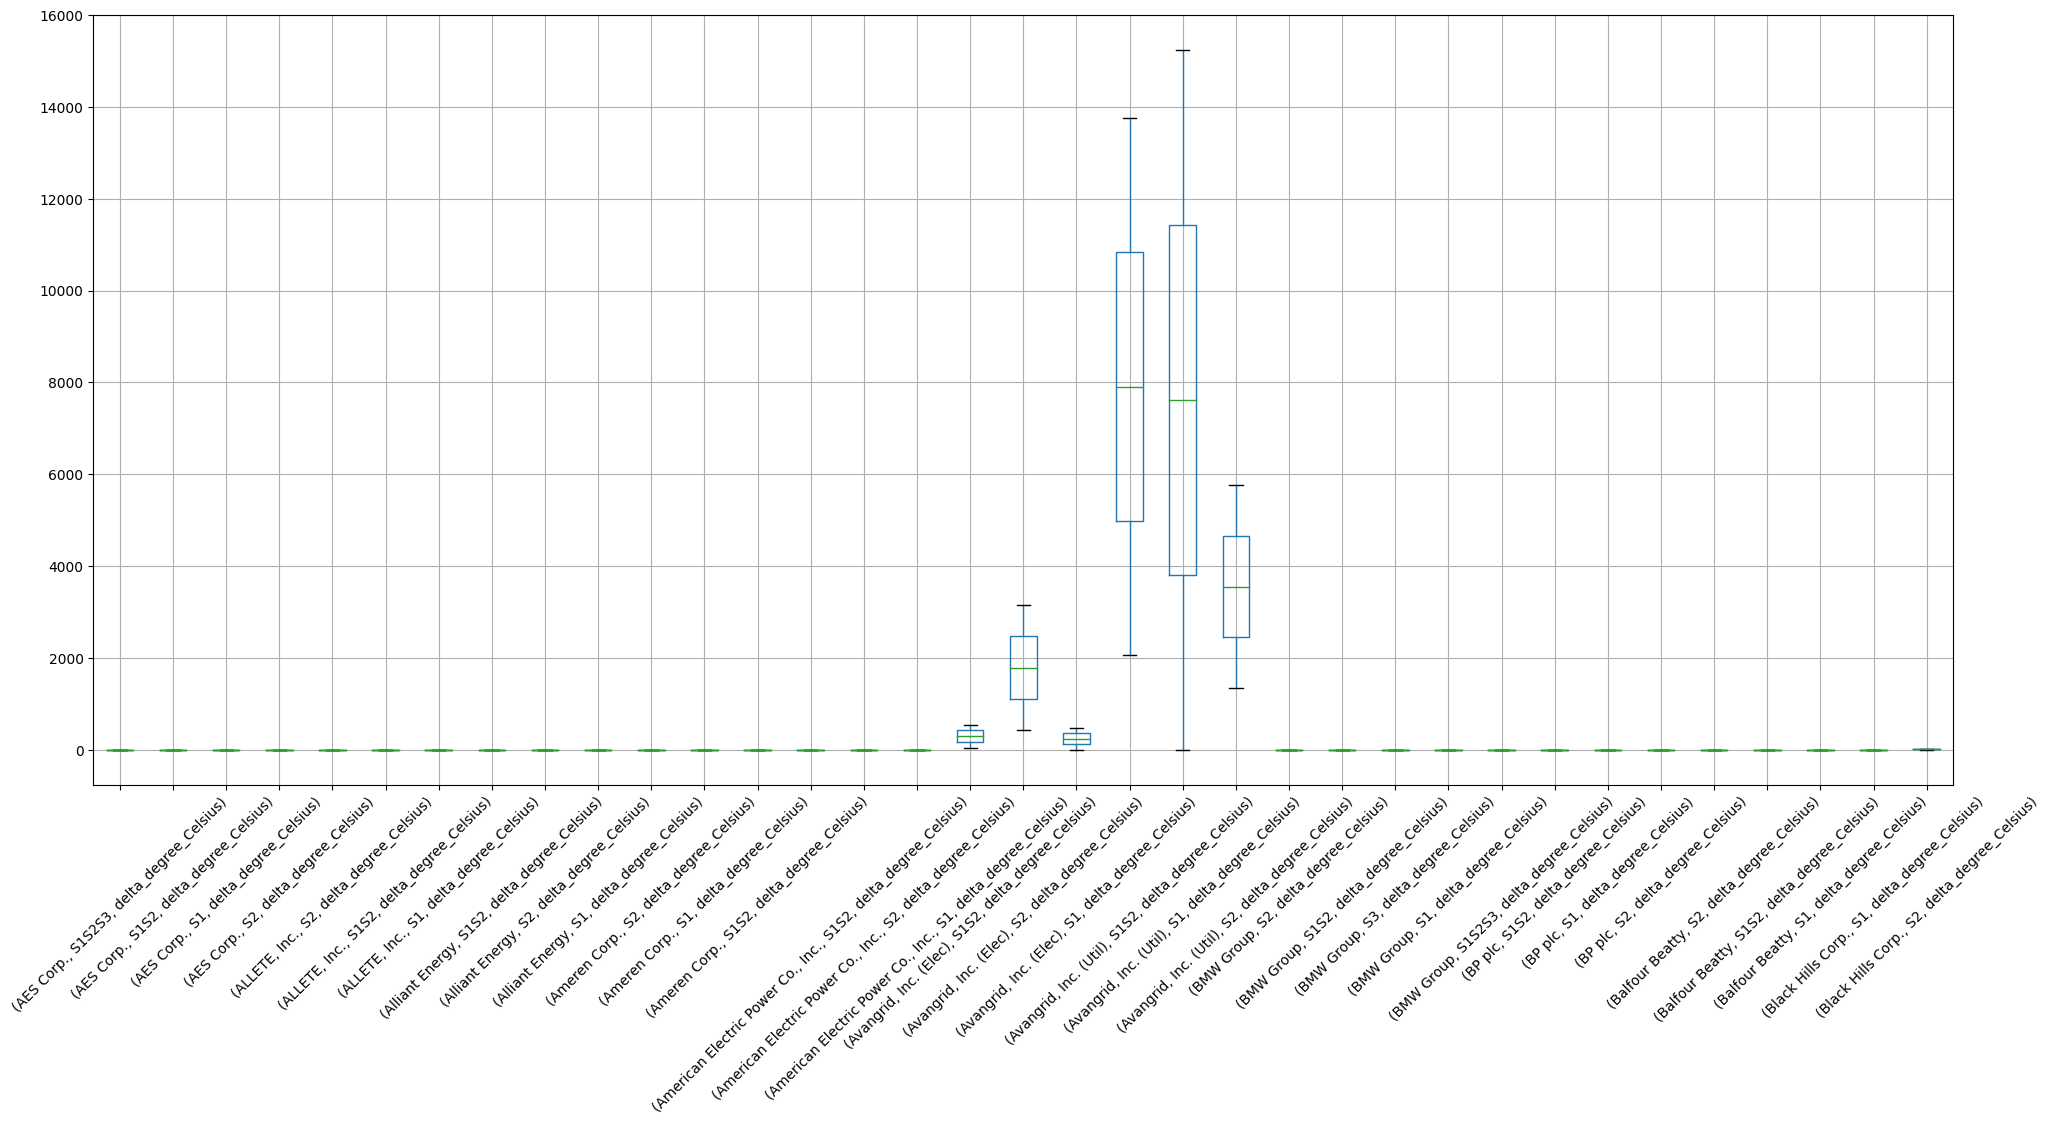

In [12]:
# Must plot the first few columns, but then plot 1/3rd of the companies so as not to over-clutter the graph
plottable_df.dropna(axis=1, how="all").iloc[:, 0:35].boxplot(figsize=(24, 10), rot=45)

### Step 5: Show per-company temperature score and weighted portfolio alignment score

Portfolio weighting scores (which ultimately influence portfolio alignment score) include:
* WATS (size of portfolio company positions used as weights)
* TETS (size of total emissions of portfolio companies used as weights)
* Financial fundamental weights:
    * Market Cap
    * Enterprise Value
    * Assets
    * Revenues

We can pass a list of company IDs to the Data Vault to get back a sum without exposing granular data

Show that we *can also* access both cumulative emissions (input) and temperature scores (output)

In [13]:
# loading sample portfolio
df_portfolio = pd.read_excel(company_data_path, sheet_name="Portfolio", index_col="company_id")

for i, col in enumerate(df_portfolio.columns):
    if col.startswith("investment_value"):
        if match := re.match(r".*\[([A-Z]{3})\]", col, re.I):
            df_portfolio.rename(columns={col: "investment_value"}, inplace=True)
            df_portfolio["investment_value"] = df_portfolio["investment_value"].astype(f"pint[{match.group(1)}]")
df_portfolio = df_portfolio.assign(scope="S1S2").set_index("scope", append=True)

### Calculate portfolio alignment temperature score based on WATS

We can do this with information exclusive to the user space (and the probability-adjusted temperature scores)

Note that companies with no production information (such as TITAL INTERNATIONAL INC and UNIVERSAL STAINLESS & ALLOY PRODUCTS INC will show NaN (Not a Number) as a score.

In [14]:
# PA_SCORE means "Probability-Adjusted" Temperature Score
df_portfolio["pa_score"] = vault_warehouse.get_pa_temp_scores(
    probability=0.5, company_ids=df_portfolio.index.values
).astype("pint[delta_degC]")

ValueError: cannot handle a non-unique multi-index!

In [ ]:
# portfolio_df[portfolio_df.company_name=='POSCO']
portfolio_df.dropna(inplace=True)
portfolio_df.sort_values(by="company_name")

In [ ]:
weight_for_WATS = portfolio_df["investment_value"].sum()
weight_for_WATS

In [ ]:
portfolio_df["WATS_weight"] = portfolio_df["pa_score"] * (portfolio_df["investment_value"] / weight_for_WATS)
portfolio_df.head()

In [ ]:
print(f"Portfolio temperature score based on WATS = {portfolio_df['WATS_weight'].sum()}")

### Calculate portfolio alignment temperature score based on TETS

We need to carefully meld portfolio data with corp fundamental data (in this case, emissions)

In [ ]:
portfolio_df["TETS_weight"] = vault_company_data.compute_portfolio_weights(
    portfolio_df["pa_score"], 2019, "emissions", EScope.S1S2
).astype("pint[delta_degC]")
portfolio_df.head()

In [ ]:
print(f"Portfolio temperature score based on TETS = {portfolio_df['TETS_weight'].sum()}")

### Calculate portfolio alignment temperature score based on MOTS, EOTS, ECOTS, AOTS, and ROTS

* MOTS = market cap weights
* EOTS = enterprise value weights
* ECOTS = EVIC weights
* AOTS = asset weights
* ROTS = revenue weights

In [ ]:
portfolio_df.dtypes

In [ ]:
weighting_dict = {
    "MOTS": "company_market_cap",
    "EOTS": "company_ev",
    "ECOTS": "company_evic",
    "AOTS": "company_total_assets",
    "ROTS": "company_revenue",
}

for k, v in weighting_dict.items():
    weight_column = f"{k}_weight"
    portfolio_df[weight_column] = vault_company_data.compute_portfolio_weights(
        portfolio_df["pa_score"], 2019, v, EScope.S1S2
    )
    print(f"Portfolio temperature score based on {k} = {portfolio_df[weight_column].sum()}")

portfolio_df

### Companies for which we lack production data (and thus cannot chart)

In [ ]:
portfolio_df[portfolio_df.pa_score.isnull()]

In [ ]:
osc._do_sql(f"select * from {ingest_schema}.{itr_prefix}company_data", engine_quant, verbose=False)